<a href="https://colab.research.google.com/github/papagorgio23/GamblingTwitter_Bot/blob/master/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Assignment 4: Generative Neural Networks

<br>

**Jason Lee**

<br>

Artificial Intelligence and Deep Learning 

2019FA MSDS 458-56
Northwestern University, SPS


# Chatbots

## Start Up

### Connect to Account

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# set working directory
import os
os.chdir("/content/drive/My Drive/458 - Deep Learning/Research 4/")
os.getcwd()

'/content/drive/My Drive/458 - Deep Learning/Research 4'

In [0]:
# list files in directory
!ls

best_model.h5		pika_chat_model.h5	  Schwimer_chatbot_model.h5
Chatbot.ipynb		Pikachu_best_model.h5	  Xpert_best_model.h5
Knish_best_model.h5	Pikachu_chatbot_model.h5  Xpert_chatbot_model.h5
Knish_chatbot_model.h5	rufus_chat_model.h5
model.png		Schwimer_best_model.h5


### Upgrade to TensorFlow 2.1.0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import keras


TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.5


### Load Packages

In [0]:
## data wrangling
import pandas as pd
import numpy as np
import re

## plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
from tensorflow.keras.utils import plot_model

## misc
import json
import datetime
import warnings
warnings.filterwarnings("ignore")
import pickle
from collections import Counter
from IPython.display import clear_output

## Deep Learning
import keras


## pre-processing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.np_utils import to_categorical 
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer


## models
from tensorflow.python.keras import models
from tensorflow.python.keras.models import Sequential, Model, load_model

## layers
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Embedding, Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Bidirectional, GlobalMaxPooling1D, Activation, Input

## word embedding
import gensim.downloader as api

## optimizer
from tensorflow.keras.optimizers import Adam, RMSprop

## evaluating model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, LambdaCallback, EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

### Write Functions

In [0]:
#### Function to put every tweet (row) in dataframe into a single string
## To start each tweet we will add a sequence of "|" for the model to learn where tweets begin and end
def concatenate_list_data(list, seq_length = 20):
      start_tweet1 = '|' * seq_length 
      result = start_tweet1
      for element in list:
	        result += str(element) + start_tweet1
      return result

#### Function to create the X and Y inputs for the RNN models
def generate_sequences(token_list, step):

    # get the total number of unique words (vocab) used in all the tweets
    total_words = len(set(token_list)) + 1
    
    # initialize x and y values
    X = []
    y = []

    # loop through tweets adding a sequence of words to x and adding the next word as the y
    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])
    
    # transform y value to sparse matrix to feed into RNN model
    y = np_utils.to_categorical(y, num_classes = total_words)
    
    # convert X and y into arrays to feed into RNN model
    X = np.array(X)
    y = np.array(y)
    
    num_seq = len(X)
    print('Number of prediction classes (Total Vocabulary):', total_words)
    print('Number of sequences:', num_seq, "\n")
    
    return X, y, num_seq



#### Function to sample predicted words based on the predicited probability distribution adding  
#### a smoothing function (temperature) to the distribution to allow the chatbot flexibility
def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


#### Function to generate new tweets with the RNN model 
def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    
    start_tweet = '| ' * seq_length
    seed_text = start_tweet + seed_text
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)
        
        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]
            
        if output_word == "|":
            break
            
        if token_type == 'word':
            output_text += output_word + ' '
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '
            
            
    return output_text


#### Function to print out prediction at various temperature levels after each epoch during training
def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 500
    print()
    print()
    print()
    print("-" * 50)
    print('Temp 0.2:')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print("-" * 50)
    print('Temp 0.33:')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print("-" * 50)
    print('Temp 0.5:')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print("-" * 50)
    print('Temp 0.67:')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.67))
    print("-" * 50)
    print('Temp 1.0:')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))
    print("-" * 50)
    print()
    print()
    print()



#### Function to generate new tweets with the RNN model with human input to start the tweet
def generate_human_led_text(model, max_sequence_len):
    
    output_text = ''
    seed_text = start_tweet
    
    while 1:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0]

        top_10_idx = np.flip(np.argsort(probs)[-10:])
        top_10_probs = [probs[x] for x in top_10_idx]
        top_10_words = tokenizer.sequences_to_texts([[x] for x in top_10_idx])
        
        for prob, word in zip(top_10_probs, top_10_words):
            print('{:<6.1%} : {}'.format(prob, word))

        chosen_word = input()
                
        if chosen_word == '|':
            break
            
        
        seed_text += chosen_word + ' '
        output_text += chosen_word + ' '
        
        clear_output()

        print (output_text)

## Load Data

In [0]:
## 12Xpert tweets
xpert_data = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/GamblingTwitter_Bot/master/Data/BOT_xpert.csv")

## Joey Knish tweets
joey_data = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/GamblingTwitter_Bot/master/Data/BOT_knish.csv")

## Michael Schwimer tweets
swim_data = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/GamblingTwitter_Bot/master/Data/BOT_swimm.csv")

## Pikachu tweets
pika_data = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/GamblingTwitter_Bot/master/Data/BOT_pikacu.csv")

In [0]:
joey_data.head()

,screen_name,text,char_length
0,JoeyKnish22,updated roy via \n\nadjustments after a week:...,314
1,JoeyKnish22,put together a low risk maybe zion gets hurt ...,368
2,JoeyKnish22,ncaa season leaders in completion % on non-s...,312
3,JoeyKnish22,knish invitational payout structure (top 2 0 ...,267
4,JoeyKnish22,joe burrow played well a year ago but his 2 0 ...,240


## Clean Data

In [0]:
## remove \n (return) in texts
xpert_data['text'] = xpert_data['text'].str.replace("\n", " ")
joey_data['text'] = joey_data['text'].str.replace("\n", " ")
swim_data['text'] = swim_data['text'].str.replace("\n", " ")
pika_data['text'] = pika_data['text'].str.replace("\n", " ")

In [0]:
## combine all his tweets
xpert = xpert_data['text']
xpert = concatenate_list_data(xpert)
joey = joey_data['text']
joey = concatenate_list_data(joey)
swimm = swim_data['text']
swimm = concatenate_list_data(swimm)
pikachu = pika_data['text']
pikachu = concatenate_list_data(pikachu)

In [0]:
xpert[:1000]

'||||||||||||||||||||since the start of the current season these are  3 8 -game running points totals. previous record was 1 0 2  held by man city and chelsea. insane.  9 7  9 7  9 7  9 7  9 7  9 7  9 9  1 0 1  9 9  9 9  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 1  1 0 4  1 0 4  1 0 4  1 0 6  1 0 8  1 0 8  1 1 0||||||||||||||||||||with full kelly staking (2 .5  %  for odds of 3  1 0  %  for odds of 1 .5 ) expectations after 1 0 0 0  bets starting bank 1 0 0 .  odds = 3 expected (mean) bank = 3 4 9 median bank = 1 8 6 chance of loss = 2 9 .0  %   odds = 1 .5 expected (mean) bank = 1 4 6 5 8 median bank = 1 2 7 4 chance of loss = 1 2 .7  % ||||||||||||||||||||for the record here are the figures for homes. all homes average o/c = 0 .9 9 9 5 winning homes = 1 .0 0 6 7 losing homes = 0 .9 9 3 8 t = 2 6  p = 1 e-1 5 1  figures for aways. all aways average o/c = 1 .0 0 1 2 winning aways = 1 .0 1 2 5 losing aways = 0 .9 9 6 7 t = 2 2  p = 8 e-1 1 0||||||||||||||||||||s

In [0]:
joey[:1000]

'||||||||||||||||||||updated roy via    adjustments after a week:  white +1 0 0 0  - +5 0 0 culver +2 0 0 0  - +5 0 0 0 hunter +4 0 0 0  - +2 5 0 0 hachimura +1 2 0 0  - +8 0 0 porter +2 0 0 0  - +5 0 0 0 washington +2 0 0 0 0  - +2 0 0 0 edwards +5 0 0 0  - +1 0 0 0 0 porter +6 0 0 0  - +1 0 0 0 0 thybulle +1 0 0 0 0 0  - +1 0 0 0 0||||||||||||||||||||put together a low risk maybe zion gets hurt  nba roy card: - garland 2 0 /1  .2 5  units  - white 2 5 /1  .2 5  units  - hayes 4 0 /1  .2  units  - herro 6 5 /1  .1 5  units  - clarke 1 0 0 /1  .1  units  - grant williams 1 0 0 /1  .1  units  - pj wash 1 0 0 /1  .1  units  - goga 2 0 0 /1  .1  units   1 .2 5  units . this will not win. but ive spent money on worse.||||||||||||||||||||ncaa season leaders in completion  %  on non-screens  2 0 1 9 : joe burrow 7 7 .2  %  2 0 1 8 : gardner minshew 6 9 .1  %  2 0 1 7 : baker mayfield 6 6 .1  %  2 0 1 6 : luke falk 6 5 .7  %  2 0 1 5 : luke falk 6 6 .0  %  2 0 1 4 : cody kessler 6 7 .3  %   b

In [0]:
swimm[:1000]

'||||||||||||||||||||below is our record by month.  all publicly verifiable picks.  all 1  unit.  all vs. best available line in us.   2 0 1 9 feb +2 2 .0 0 mar +2 5 .6 0 apr +6 .6 2 may -1 1 .1 4 june +1 1 .8 5 july +4 0 .3 aug +1 1 .6 9 sep +0 .3 1 oct +4 .8 8 nov -2 7 .8 1 dec +5 0 .4 5 2 0 2 0 jan -4 2 .8 feb +1 6 .7  total +1 0 8 .6 5||||||||||||||||||||complete jambos record of only publicly available picks vs. betcris at tor format= total recs (minus pushes) total units -1 1 0  adjusted winning %   nfl= 2 4 6  +1 4 .7 9  5 5 .2 4  %  mlb= 1 4 5 9  +3 9 .9 8  5 3 .6 9  %  ncaabb= 1 0 7 8  +.8 5  5 2 .4 2  %  ncaaf= 4 0 1  -1 0 .3  5 1 .1 5  %  overall= 3 1 8 4  +4 5 .3 2  5 3 .0 7  % ||||||||||||||||||||decent week. complete jambos record of only publicly available picks vs. betcris at tor format= total recs(- pushes)/total units/-1 1 0  adjusted winning %   overall= 3 2 7 9 /+5 0 .1 6 /5 3 .1 1  %  nfl= 2 7 0 /+1 9 .6 8 /5 5 .8 5  %  mlb= 1 4 5 9 /+3 9 .9 8 /5 3 .6 9  %  ncaabb=

In [0]:
pikachu[:1000]

'||||||||||||||||||||boringggg. who cares. here are my current bottom 1 5  power rankings...any hot takes??  3 5 3  mvsu 3 5 2  chicago st 3 5 1  delaware st 3 5 0  kennesaw st 3 4 9  apb 3 4 8  ccsu 3 4 7  howard 3 4 6  umes 3 4 5  hou baptist 3 4 4  holy cross 3 4 3  incarnate word 3 4 2  al am 3 4 1  se la 3 4 0  high point 3 3 9  tenn tech||||||||||||||||||||so on leap year day in the year of our lord 2 0 2 0  the xfl:  - went for it 4 th down on own 2 8  down by 8  in 3 q - tried 3 -pt pat down by 4  in early 4 q - punted 4 th  inches from the 5 0  down by 2  scores - outgained opponent 3 7 0 -2 7 2  on yardage lost by 3  this league is the||||||||||||||||||||1 . for -1 1 0  its 5 2 .3 8  %  you cant just round down by .0 8  thats a big diff 2 . totals get shaded af and by day of are rarely still -1 0 . but you dont include odds so you just take a freeroll on the -1 5 /-2 0 . today was an exception but thats bc you know weve been calling you out||||||||||||||||||||yes it would. br

In [0]:
## create a space between special characters to decrease the vocabulary size for each user
xpert = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~1234567890])', r' \1 ', xpert)
xpert = re.sub('\s{2,}', ' ', xpert)
joey = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~1234567890])', r' \1 ', joey)
joey = re.sub('\s{2,}', ' ', joey)
swimm = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~1234567890])', r' \1 ', swimm)
swimm = re.sub('\s{2,}', ' ', swimm)
pikachu = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~1234567890])', r' \1 ', pikachu)
pikachu = re.sub('\s{2,}', ' ', pikachu)

In [0]:
pikachu[:1000]

' | | | | | | | | | | | | | | | | | | | | boringggg . who cares . here are my current bottom 1 5 power rankings . . . any hot takes ? ? 3 5 3 mvsu 3 5 2 chicago st 3 5 1 delaware st 3 5 0 kennesaw st 3 4 9 apb 3 4 8 ccsu 3 4 7 howard 3 4 6 umes 3 4 5 hou baptist 3 4 4 holy cross 3 4 3 incarnate word 3 4 2 al am 3 4 1 se la 3 4 0 high point 3 3 9 tenn tech | | | | | | | | | | | | | | | | | | | | so on leap year day in the year of our lord 2 0 2 0 the xfl : - went for it 4 th down on own 2 8 down by 8 in 3 q - tried 3 - pt pat down by 4 in early 4 q - punted 4 th inches from the 5 0 down by 2 scores - outgained opponent 3 7 0 - 2 7 2 on yardage lost by 3 this league is the | | | | | | | | | | | | | | | | | | | | 1 . for - 1 1 0 its 5 2 . 3 8 % you cant just round down by . 0 8 thats a big diff 2 . totals get shaded af and by day of are rarely still - 1 0 . but you dont include odds so you just take a freeroll on the - 1 5 / - 2 0 . today was an exception but thats bc you know weve been c

In [0]:
import string

testing = pikachu.split()
# remove punctuation from each token
table = str.maketrans('', '', string.punctuation)
testing = [w.translate(table) for w in testing]
# remove remaining tokens that are not alphabetic
testing = [word for word in testing if word.isalpha()]

In [0]:
# Python program to find the k most frequent words 
# from data set 
from collections import Counter 

# Pass the split_it list to instance of Counter class. 
Counter = Counter(testing) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(25) 

print(most_occur) 

[('the', 1777), ('to', 1496), ('you', 1474), ('a', 1448), ('is', 988), ('and', 878), ('i', 875), ('of', 862), ('this', 700), ('for', 652), ('on', 648), ('that', 641), ('in', 593), ('it', 590), ('your', 494), ('not', 483), ('but', 409), ('are', 405), ('so', 371), ('be', 361), ('he', 357), ('about', 353), ('with', 345), ('lol', 343), ('just', 341)]


In [0]:
word_feq = pd.DataFrame.from_dict(Counter, orient='index').reset_index()

In [0]:
word_feq.columns = ['Word', 'Frequency']
word_feq.sort_values(by='Frequency', ascending=False).reset_index(drop=True).head(50)

,Word,Frequency
0,the,1777
1,to,1496
2,you,1474
3,a,1448
4,is,988
5,and,878
6,i,875
7,of,862
8,this,700
9,for,652


## Exploratory Data Analysis

In [0]:
# from data set 
from collections import Counter 

# Pass the split_it list to instance of Counter class. 
Counter = Counter(tokens) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(25) 

print(most_occur) 

# Joseph Buchdahl (@12Xpert)

In [0]:
# define twitter user
user = "Xpert"

## Create Vocabulary

In [0]:
# initialize tokenizer
tokenizer = Tokenizer(char_level = False, filters = '', num_words=5500)

# fit tokenizer on tweets
tokenizer.fit_on_texts([xpert])

# tokenize tweets
token_list = tokenizer.texts_to_sequences([xpert])[0]

# get vocabulary in tweets
all_words = len(tokenizer.word_counts) + 1
total_words = len(set(token_list)) + 1

In [0]:
print(user, "has a vocabulary of", all_words, "total words!")
if all_words > 5500:
    print("\n", user, "uses so many words that we need to limit his vocabulary for modeling to only", total_words, "total words!")

Xpert has a vocabulary of 8163 total words!

 Xpert uses so many words that we need to limit his vocabulary for modeling to only 5500 total words!


## Create Training Data

Convert tweets into sequences to input into the RNN model

In [0]:
# step = the number of words the sequence moves before creating a new sequence
step = 1
# total words in each sequence
seq_length = 20

## create training data
X, y, num_seq = generate_sequences(token_list, step = 1)

Number of prediction classes (Total Vocabulary): 5500
Number of sequences: 233367 



In [0]:
# make sure Y data lines up with the function output above
y.shape

(233367, 5500)

## Build Model

### Early Stopping Settings

In [0]:
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

### Model Checkpoint Settings

In [0]:
# output file to save the best model
filepath =  user + '_best_model.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

### Callback Function

In [0]:
# create callback function to generate tweets at different temperatures for the chatbot after each epoch
callback = LambdaCallback(on_epoch_end = on_epoch_end)

### Neural Network Architecture

In [0]:
# name model
model_name = user + "_Chatbot"

# number of neurons in LSTM layer
n_units = 256

# Embedding Dimensions
embedding_size = 100

# Input of model
text_in = Input(shape = (None,), name = "Tweets")

# Embedding layer
embedding = Embedding(total_words, embedding_size, name = "Embedding_Layer")

# Start of Model
x = embedding(text_in)

# LSTM RNN layer
x = LSTM(n_units, name = "RNN_Layer")(x)

# Output layer
text_out = Dense(total_words, activation = 'softmax', name = "Predict_Next_Word")(x)

# Complete model
model = Model(text_in, text_out, name = model_name)

# Optimizer function
opti = Adam(learning_rate = 0.001)

# Compile model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opti, 
              metrics = ['accuracy'])

### View Model

In [0]:
model.summary()

Model: "Xpert_Chatbot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Tweets (InputLayer)          [(None, None)]            0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, None, 100)         550000    
_________________________________________________________________
RNN_Layer (LSTM)             (None, 256)               365568    
_________________________________________________________________
Predict_Next_Word (Dense)    (None, 5500)              1413500   
Total params: 2,329,068
Trainable params: 2,329,068
Non-trainable params: 0
_________________________________________________________________


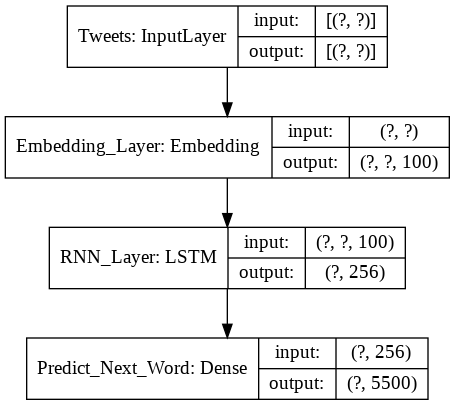

In [0]:
# plot model structure
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

## Train Model

In [0]:
# initialize variables for the callback functions in the model
seq_length = 20
start_tweet = '| ' * seq_length
token_type = 'word'

# length of training
epochs = 20
batch_size = 64
num_batches = int(len(X) / batch_size)

print("Total Batches:", str(num_batches), "\n")


# Record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()


model.fit(X, y, 
          validation_split=0.15,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks = [callback, checkpoint, earlystop], 
          shuffle = True)

## Save Model
model_saved_name = user + '_chatbot_model.h5'
model.save_weights(model_saved_name)

end = datetime.datetime.now()
time_diff = end-start
print()
print()
print('Time to train = {}'.format(time_diff))

Total Batches: 3646 

Train on 198361 samples, validate on 35006 samples
Epoch 1/20
198336/198361 [============================>.] - ETA: 0s - loss: 4.2316 - accuracy: 0.3769


--------------------------------------------------
Temp 0.2:
i the point of the a the . i the the a be . i a be a be . 
--------------------------------------------------
Temp 0.33:
i don't be a be . there . i the mean and the the model . i you have . 
--------------------------------------------------
Temp 0.5:
this might be . the is the know that only not be is . betting you are back . if it . 
--------------------------------------------------
Temp 0.67:
why this for a be for the that you a complaining . what all you the get it . 
--------------------------------------------------
Temp 1.0:
on it tells i more : the against true major telling on at have been wage other ( is take rose from touts model for it to now frankly and mean understand million speaking higher . 
------------------------------------------

## Plot Model Training

### Accuracy

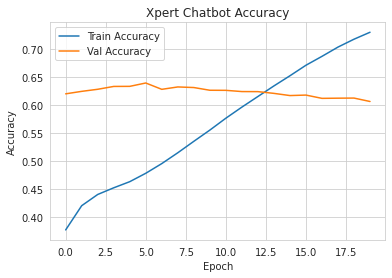

In [0]:
# Plot training & validation accuracy values
plot_title = user + " Chatbot Accuracy"
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title(plot_title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='upper left')
plt.show()

### Loss/Cost

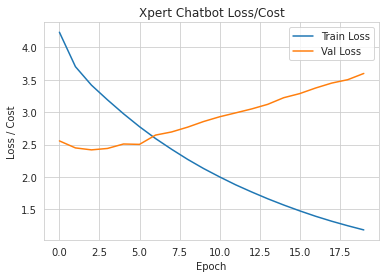

In [0]:
# Plot training & validation loss values
plot_title = user + " Chatbot Loss/Cost"
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title(plot_title)
plt.ylabel('Loss / Cost')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

## Use Chatbot

### Load Best Model

In [0]:
# load best saved model
best_model = load_model(filepath)

### Temperature: 0.1

In [0]:
# Chatbot's new Tweet
temp = 0.1
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.1

Xpert Chatbot Tweet 1:
i think the point is that the yellow line actually is . if you are not talking about it all my time . 

Xpert Chatbot Tweet 2:
i think the point is that the response to the " secret report " . . . . g useless and are tossing coins . 

Xpert Chatbot Tweet 3:
but you still haven't shown for the two data i . e . g . 5 0 % for the profits of 6 5 . 5 % from 4 5 % . 

Xpert Chatbot Tweet 4:
i would say shame that you have a dialogue channel . if you were talking about this then you would be happy to respond to a huge intelligent just by a non - comparison of the process with a good go of the house edge . still only in 1 4 days ago the success is being possible to suggest that the market is random . 

Xpert Chatbot Tweet 5:
i think the point is that the yellow line actually is . if you are not talking about it then it's not a question of how long does it is . 



### Temperature: 0.2

In [0]:
# Chatbot's new Tweet
temp = 0.2
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.2

Xpert Chatbot Tweet 1:
if you mean they wouldn't be fully efficient but they can be errors in the end why would anyone pay me to embark on your own bookmaker . we think this is the case that man city thought have been used in the original time . 

Xpert Chatbot Tweet 2:
but the point is that the biggest stakers are the sharp bookmaker they want to be in the time . 

Xpert Chatbot Tweet 3:
i think the point is that the yellow line actually is . if you are not talking about it all time and then really not going to test it . 

Xpert Chatbot Tweet 4:
the latest 2 0 1 9 - 2 0 title race timeline based on my predictions ( method at ) . data by 

Xpert Chatbot Tweet 5:
but it's the unintended consequences that are not the slightest idea . if it is a very nuanced concept . 



### Temperature: 0.3

In [0]:
# Chatbot's new Tweet
temp = 0.3
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.3

Xpert Chatbot Tweet 1:
but you still haven't shown for the two data i . e . comparing into your turnover and see average . 

Xpert Chatbot Tweet 2:
i know i know . the point is that if it was the way to make a living from betting companies . 

Xpert Chatbot Tweet 3:
the latest 2 0 1 9 - 2 0 title race timeline based on my predictions ( method at ) . data by 

Xpert Chatbot Tweet 4:
if you mean a few / price / price odds / roi from 1 . 9 5 / 1 . 9 5 and 3 8 p - value = 0 . 0 5 e . method = 4 . 4 9 % avg odds = 4 . 2 8 t = 0 . 9 8 4 9 t = 0 . 9 5 % 5 1 / 1 0 4 for me that will be enough as much changes . expected roi = 0 . 1 9 / 1 9 9 9 9 9 7 9 9 9 7 9 . 9 9 % roi of 1 . 0 0 0 0 0 0 0 0 0 0 0 . given the 2 . 9 % roi from 2 2 1 0 0 1 0 . so suppose 4 . 9 % from 2 5 % of 9 9 % if 5 3 8 picks . if 9 5 % of the total come from the total area about 1 1 in 5 3 8 's 1 . 9 5 and the value was 5 0 % of the time . 

Xpert Chatbot Tweet 5:
i think the argument that doesn't have to

### Temperature: 0.4

In [0]:
# Chatbot's new Tweet
temp = 0.4
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.4

Xpert Chatbot Tweet 1:
you don't know . i don't know how much i would have to do to be betting or more than they do so . 

Xpert Chatbot Tweet 2:
so . but when you want to talk about pyckio here's the eu to avoid the confusion but i don't have to try to educate people to make it work . 

Xpert Chatbot Tweet 3:
yes i agree that is the point . paradox of skill starts a betting market ( expected roi ) for my view ) . i suspect that log method will for be linearly proportional to betshare % . 

Xpert Chatbot Tweet 4:
i would say shame that if you know what the amount you know . 'true' line is meaningless because its not almost random . 

Xpert Chatbot Tweet 5:
the latest 2 0 1 9 - 2 0 title race timeline based on my predictions ( method at ) . data by 



### Temperature: 0.5

In [0]:
# Chatbot's new Tweet
temp = 0.5
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.5

Xpert Chatbot Tweet 1:
this is exactly what happens in the context of betting overs to pinnacle / or surely you would have on positive than . 

Xpert Chatbot Tweet 2:
but when i think it's a scam it's chapter 1 0 years . but she will be a negative yield and difference . we have to talk about this . 

Xpert Chatbot Tweet 3:
but it's the unintended consequences that are not the point . best if indeed it offers you are useful anyway . 

Xpert Chatbot Tweet 4:
but you still haven't answer my original question in my mind . and the long term it would be more efficient than other other than the vig and how many are close . 

Xpert Chatbot Tweet 5:
no i would say it again . i still don't know how to set from your customer name . ill also be banned for my troubles . maxi's . 



### Temperature: 0.6

In [0]:
# Chatbot's new Tweet
temp = 0.6
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.6

Xpert Chatbot Tweet 1:
but this is this matter what the press talking about " winners " and as " " so be " . " . " expected = % from 5 % chance is almost no good . " 

Xpert Chatbot Tweet 2:
i know the point . and if neverleavers exploit them " easy " do " bias " instead of counting and skill ( and natural expectation ) ? source for example 8 thousand on this linear for curve still 

Xpert Chatbot Tweet 3:
this is just an obvious reality . i haven't noticed . i have to read the piece if we consider doing this truth . if you read the view that this is the same thing and the only thing for that they are and managing risks . that is why you might not be talking to the true probability that it might explain why . 

Xpert Chatbot Tweet 4:
i would say shame we are . if we mean it's a few who would or go down . their fans way gambling is a little bit of those who think they are not . 

Xpert Chatbot Tweet 5:
give me a lot of modelling than the affiliate industry today . i ag

### Temperature: 0.7

In [0]:
# Chatbot's new Tweet
temp = 0.7
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.7

Xpert Chatbot Tweet 1:
i think you can certainly be left from the pre - the odds from 1 5 . the do that is that it's possible to imply greater fair price . so it's still paying for a wider variance in parliament . 

Xpert Chatbot Tweet 2:
you will but you have to be suggesting we wouldnt see the problem of " winners " to make it better because of this privately and my majority are socioeconomically able to pass in . 

Xpert Chatbot Tweet 3:
i would say shame that the reason all for skilled records is about 9 9 % who are in - year . it's not enough to overcome the margin . 

Xpert Chatbot Tweet 4:
i didn't say i would say that is a decent point and go nuts . but has yet been banned by the paradox of sharp bettors . 

Xpert Chatbot Tweet 5:
if you mean market efficiency or you are more than 1 % . you would need to lose a bonferroni correction . here's a p - value where - 4 knowing how you don't have the data shut to change your expected . 



### Temperature: 0.8

In [0]:
# Chatbot's new Tweet
temp = 0.8
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.8

Xpert Chatbot Tweet 1:
i'm not asking out i simply have to in the book that at is a serious market . which might look down like it's harder to handle law . 

Xpert Chatbot Tweet 2:
are just a little left for me . i've been about one of and / economy which is there are other quicker . 

Xpert Chatbot Tweet 3:
a blog agree to know how a reason to say " model " to retag and knowledge particularly about allowing who that is bringing to the market you exploit it . 

Xpert Chatbot Tweet 4:
i would paradox of the sample of 1 1 . 5 but at least the problem it would be able to account for bookmakers . 

Xpert Chatbot Tweet 5:
it is similar for main league . i imagine it's not a bit by that i will never claim to win so much . 



### Temperature: 0.9

In [0]:
# Chatbot's new Tweet
temp = 0.9
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.9

Xpert Chatbot Tweet 1:
i think this is the common different moral of the cycle that sees moral attitudes to gambling flip . there will be anything else to achieve that there are other reasons ? 

Xpert Chatbot Tweet 2:
the fact that recreationals artificially shift markets ? if they beat the closing price ( and most industry then compare for the more there is the bad very dealing in the size of the correct . but with the other hand it all the p - value will be left winner to see and feel better and it had to a closing price . that's the true but it would seem to have a few of the market . 2 % balancing action would be expected to be born 

Xpert Chatbot Tweet 3:
week your bayes factor punters for fivethirtyeight there are not perfectly efficient at least that is what you are . 

Xpert Chatbot Tweet 4:
you just gotta love you simply and see your trading gets words to describe what he bets has might be left has been pointed out . perhaps might there . 

Xpert Chatbot Tw

### Temperature: 1.0

In [0]:
# Chatbot's new Tweet
temp = 1.0
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 1.0

Xpert Chatbot Tweet 1:
was for the principle of labour follow increase these large numbers . that is good correlation . you would also be told that goal can get in a betting markets to make us get close to why when they were going forward to attract bookmakers rather than them are anyway . that's not it to see for anything . 

Xpert Chatbot Tweet 2:
if they were 1 % who it's willing for place to exist . that's impossible to ban winners at a pinnacle like having respect to his position in the place . given it's already who can seem a person out to his paper worth it . rather going on a decent ! ! ! 

Xpert Chatbot Tweet 3:
if you're keen on markets think you've got it not well it almost everyone " you are very good at sharing it than . 

Xpert Chatbot Tweet 4:
the only place is whether were a coin flipper with a big records which can't happen to be verified with that you will get access to luck goal . 

Xpert Chatbot Tweet 5:
it's almost always true . for histories but

# Joey Knish (@JoeyKnish22)

In [0]:
# define twitter user
user = "Knish"

## Create Vocabulary

In [0]:
# initialize tokenizer
tokenizer = Tokenizer(char_level = False, filters = '', num_words=5500)

# fit tokenizer on tweets
tokenizer.fit_on_texts([joey])

# tokenize tweets
token_list = tokenizer.texts_to_sequences([joey])[0]

# get vocabulary in tweets
all_words = len(tokenizer.word_counts) + 1
total_words = len(set(token_list)) + 1

In [0]:
print(user, "has a vocabulary of", all_words, "total words!")
if all_words > 5500:
    print("\n", user, "uses so many words that we need to limit his vocabulary for modeling to only", total_words, "total words!")

Knish has a vocabulary of 8413 total words!

 Knish uses so many words that we need to limit his vocabulary for modeling to only 5500 total words!


## Create Training Data

Convert tweets into sequences to input into the RNN model

In [0]:
# step = the number of words the sequence moves before creating a new sequence
step = 1
# total words in each sequence
seq_length = 20

## create training data
X, y, num_seq = generate_sequences(token_list, step = 1)

Number of prediction classes (Total Vocabulary): 5500
Number of sequences: 186110 



In [0]:
# make sure Y data lines up with the function output above
y.shape

(186110, 5500)

## Build Model

### Early Stopping Settings

In [0]:
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

### Model Checkpoint Settings

In [0]:
# output file to save the best model
filepath =  user + '_best_model.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

### Callback Function

In [0]:
# create callback function to generate tweets at different temperatures for the chatbot after each epoch
callback = LambdaCallback(on_epoch_end = on_epoch_end)

### Neural Network Architecture

In [0]:
# name model
model_name = user + "_Chatbot"

# number of neurons in LSTM layer
n_units = 256

# Embedding Dimensions
embedding_size = 100

# Input of model
text_in = Input(shape = (None,), name = "Tweets")

# Embedding layer
embedding = Embedding(total_words, embedding_size, name = "Embedding_Layer")

# Start of Model
x = embedding(text_in)

# LSTM RNN layer
x = LSTM(n_units, name = "RNN_Layer")(x)

# Output layer
text_out = Dense(total_words, activation = 'softmax', name = "Predict_Next_Word")(x)

# Complete model
model = Model(text_in, text_out, name = model_name)

# Optimizer function
opti = Adam(learning_rate = 0.001)

# Compile model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opti, 
              metrics = ['accuracy'])

### View Model

In [0]:
model.summary()

Model: "Knish_Chatbot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Tweets (InputLayer)          [(None, None)]            0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, None, 100)         550000    
_________________________________________________________________
RNN_Layer (LSTM)             (None, 256)               365568    
_________________________________________________________________
Predict_Next_Word (Dense)    (None, 5500)              1413500   
Total params: 2,329,068
Trainable params: 2,329,068
Non-trainable params: 0
_________________________________________________________________


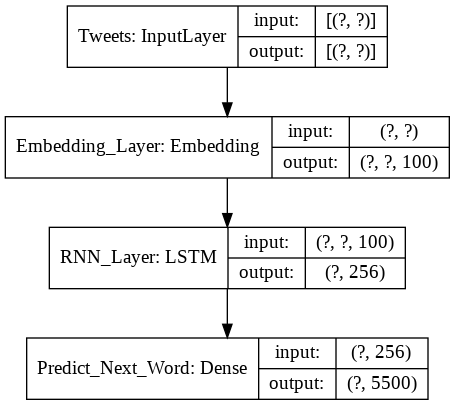

In [0]:
# plot model structure
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

## Train Model

In [0]:
# initialize variables for the callback functions in the model
seq_length = 20
start_tweet = '| ' * seq_length
token_type = 'word'

# length of training
epochs = 20
batch_size = 64
num_batches = int(len(X) / batch_size)

print("Total Batches:", str(num_batches), "\n")


# Record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()


model.fit(X, y, 
          validation_split=0.15,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks = [callback, checkpoint, earlystop], 
          shuffle = True)

## Save Model
model_saved_name = user + '_chatbot_model.h5'
model.save_weights(model_saved_name)

end = datetime.datetime.now()
time_diff = end-start
print()
print()
print('Time to train = {}'.format(time_diff))

Total Batches: 2907 

Train on 158193 samples, validate on 27917 samples
Epoch 1/20
158144/158193 [============================>.] - ETA: 0s - loss: 4.2332 - accuracy: 0.4339


--------------------------------------------------
Temp 0.2:

--------------------------------------------------
Temp 0.33:

--------------------------------------------------
Temp 0.5:

--------------------------------------------------
Temp 0.67:

--------------------------------------------------
Temp 1.0:

--------------------------------------------------




Epoch 00001: loss improved from inf to 4.23348, saving model to Knish_best_model.h5
158193/158193 [==============================] - 242s 2ms/sample - loss: 4.2335 - accuracy: 0.4338 - val_loss: 2.3789 - val_accuracy: 0.6687
Epoch 2/20
158144/158193 [============================>.] - ETA: 0s - loss: 3.7679 - accuracy: 0.4499


--------------------------------------------------
Temp 0.2:
i dont be the be the 2 0 0 0 - 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Plot Model Training

### Accuracy

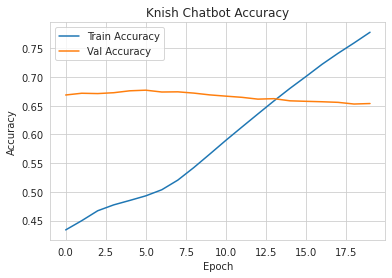

In [0]:
# Plot training & validation accuracy values
plot_title = user + " Chatbot Accuracy"
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title(plot_title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='upper left')
plt.show()

### Loss/Cost

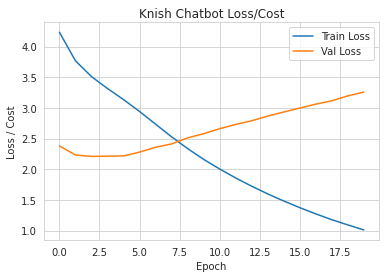

In [0]:
# Plot training & validation loss values
plot_title = user + " Chatbot Loss/Cost"
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title(plot_title)
plt.ylabel('Loss / Cost')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

## Use Chatbot

### Load Best Model

In [0]:
# load best saved model
best_model = load_model(filepath)

### Temperature: 0.1

In [0]:
# Chatbot's new Tweet
temp = 0.1
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.1

Knish Chatbot Tweet 1:
i think its a light mac book . hillbillys love golf for a little being p 1 0 months . i like this game . but if you took the least an playoffs with a couple more days . 

Knish Chatbot Tweet 2:
i think the one guys at the game . but its not too much at the conference and a prize week . 

Knish Chatbot Tweet 3:
i think its a light mac book . hillbillys love golf . buy twitter before live betting becomes . 

Knish Chatbot Tweet 4:
i think the one guys at the office that are from the front office . 

Knish Chatbot Tweet 5:
i think the one guys at the game . but its not too much at the conference and a player to get the run for 3 0 thousand giveaway before he was 1 0 . 5 qbs in the 4 9 ers 1 6 . 



### Temperature: 0.2

In [0]:
# Chatbot's new Tweet
temp = 0.2
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.2

Knish Chatbot Tweet 1:
i think im gonna stop in tomorrow night . i think a ticket at me and see the ticket will be dead if they can take the popular vote ( say this year ) 

Knish Chatbot Tweet 2:
i think the one guys at the office they just depends for a couple points in the panel with this trash 

Knish Chatbot Tweet 3:
i think the one guys at the game . but its not too much at the conference and it in the country . and only of the pool setting about him in - 2 weeks . and i went up ? 

Knish Chatbot Tweet 4:
i think its a light mac book . hillbillys and texans / and dont like usc from regularly . 

Knish Chatbot Tweet 5:
i think its a light mac book . hillbillys love shit and metcalf and look out to the . 



### Temperature: 0.3

In [0]:
# Chatbot's new Tweet
temp = 0.3
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.3

Knish Chatbot Tweet 1:
i think i bet on rutgers at halftime . and if you miss lsu futures in a wedding contest with a game coming . 

Knish Chatbot Tweet 2:
if you have a dm to go up to stay and get the knishwich up 8 . 

Knish Chatbot Tweet 3:
i think im gonna drive franky lol but never been a couple of it 4 th but didnt get the line . 

Knish Chatbot Tweet 4:
i think its official . the touts can be a shot . great list ( tampa ) even in detroit case to make you even doing for us . 

Knish Chatbot Tweet 5:
i know you . with the load 1 7 but is too much of the . 



### Temperature: 0.4

In [0]:
# Chatbot's new Tweet
temp = 0.4
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.4

Knish Chatbot Tweet 1:
the clips couldnt keep us couldnt walk to trade . but theyll be able to retire by jack the nfl without so if i had . but at a winning one week with 1 2 - 1 9 conference title games that is going into power ratings . 

Knish Chatbot Tweet 2:
i think the have realized instagram is what the only lives off the list . 

Knish Chatbot Tweet 3:
i think the guy was also too much too . * betting nfl playoffs ? 

Knish Chatbot Tweet 4:
but i could have gotten to this . but if i feel good to canada a few hours . but im not saying it was pretty honest ? 

Knish Chatbot Tweet 5:
i know youre reeling after the rest of the oregon ol . the part of the pro bowl game is a truly fact . 



### Temperature: 0.5

In [0]:
# Chatbot's new Tweet
temp = 0.5
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.5

Knish Chatbot Tweet 1:
that moment when you go to your non / walk for 2 5 8 million ? youll be a great at home and the spread but were in the ohio - 1 4 . 5 imo . 

Knish Chatbot Tweet 2:
the hospital horror stories + lack of supplies in epicenter areas is bad . real bad . wouldnt see me following me a sandwich . 

Knish Chatbot Tweet 3:
you know if benny is dunking on ya on the al world . it was hard to form . 

Knish Chatbot Tweet 4:
i think i would have to do this . but nobody is an nba qb play : the joke i went going for me . also probably not got the best qb in the house in the country . 

Knish Chatbot Tweet 5:
i think you should stop in the game but the part of the next game . 



### Temperature: 0.6

In [0]:
# Chatbot's new Tweet
temp = 0.6
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.6

Knish Chatbot Tweet 1:
i think it comes to the . but nobodys got an personal soccer play in the night 

Knish Chatbot Tweet 2:
for the very very many game him on the 3 minutes to suspend us down the country . . . . see a special season rec buddy who could have a ton of story of every studio itself . it sucks . 

Knish Chatbot Tweet 3:
the knish incredible football he in the super bowl . the of the big in the board . 

Knish Chatbot Tweet 4:
i know what it is a bit " was 5 to make him not sure i figured this out there had to properly . 

Knish Chatbot Tweet 5:
last year bud to interview the entire site is in the world would be open for 5 thousand on football but not sure how much absolutely dm . 



### Temperature: 0.7

In [0]:
# Chatbot's new Tweet
temp = 0.7
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.7

Knish Chatbot Tweet 1:
nah if you dmd matt not a reality of his knowledge probably be fine . 

Knish Chatbot Tweet 2:
i mean hes as healthy is changed up on them for appy : ? 

Knish Chatbot Tweet 3:
if youre going to it here . not sure you gonna make it to just supply it to be shit . 

Knish Chatbot Tweet 4:
i think the funnier part is 1 5 0 times bol way to get a couple more days that would double check it off two and enjoy it . 

Knish Chatbot Tweet 5:
a mac coaching staff not realizing the bears / 4 . 5 which was a good time for him to justify what just the quick or get some prop . 



### Temperature: 0.8

In [0]:
# Chatbot's new Tweet
temp = 0.8
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.8

Knish Chatbot Tweet 1:
same . my dad thinks the saints isnt i would imagine youre the old man of gambling in the face . 

Knish Chatbot Tweet 2:
im not so a medical audience shouldnt be watching a few key states that hoping for the other michigan by a decade in 2 pm hour . i really thought the special td in the country . and were convinced putting the book has been laid to . and would feel more here . 

Knish Chatbot Tweet 3:
if you ride a nice jersey and dm it can cheap then a cover 

Knish Chatbot Tweet 4:
lmao not 5 0 0 % sure i tried to get in the last 2 0 points here they had an extra quality if ya go there to make it . penny dont think shit . 

Knish Chatbot Tweet 5:
feels like youre bordering on ben . im good to just tell me 4 in the post 



### Temperature: 0.9

In [0]:
# Chatbot's new Tweet
temp = 0.9
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.9

Knish Chatbot Tweet 1:
i think 6 of the last 1 5 hours with the greatest lead and mlb football return . but youll not be hard . and its not a super bowl qb at home but the vegas who would have about his handle for some reason as much more looking to the uncle k . 

Knish Chatbot Tweet 2:
this likely playing in the pool but of top - 6 - 5 . atta was all if it but he beats it . 

Knish Chatbot Tweet 3:
if he wins i can had a bet on tua app to make sure i dont need you steaming more more than old props . this tweet is more buying my year . . . . . and play franks 4 fantasy / playoff game game would be bet tbh once maybe we trade it not only cost him seeing and it man to only . 

Knish Chatbot Tweet 4:
you know tickets are an option ive got it to go up the water before they fight . 

Knish Chatbot Tweet 5:
new couple prop peasant cash from the super bowl . the bears not be well to have to stop myself . 



### Temperature: 1.0

In [0]:
# Chatbot's new Tweet
temp = 1.0
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 1.0

Knish Chatbot Tweet 1:
yeah hes gonna run but really in you just with him like 2 h swissman i just won a few rd . you just never won a winner . was the completely guy who you cant even look like well . 

Knish Chatbot Tweet 2:
thanks for cleaning it taking the strip today to give it back and and he was talking to bet with copy . 

Knish Chatbot Tweet 3:
good from a fucking u 1 2 5 off its last game when its not cash his preseason . 

Knish Chatbot Tweet 4:
pg ( swissman osu backup i been the greatest way for much season than i own to the state of a prize watching . 

Knish Chatbot Tweet 5:
if tannehill on sports and i think theyre actually in this : im not very a lot of money . 



# Michael Schwimer (@mschwimer)

In [0]:
# define twitter user
user = "Schwimer"

## Create Vocabulary

In [0]:
# initialize tokenizer
tokenizer = Tokenizer(char_level = False, filters = '', num_words=15000)

# fit tokenizer on tweets
tokenizer.fit_on_texts([swimm])

# tokenize tweets
token_list = tokenizer.texts_to_sequences([swimm])[0]

# get vocabulary in tweets
all_words = len(tokenizer.word_counts) + 1
total_words = len(set(token_list)) + 1

In [0]:
print(user, "has a vocabulary of", all_words, "total words!")
if all_words > 5500:
    print("\n", user, "uses so many words that we need to limit his vocabulary for modeling to only", total_words, "total words!")

Schwimer has a vocabulary of 5010 total words!


## Create Training Data

Convert tweets into sequences to input into the RNN model

In [0]:
# step = the number of words the sequence moves before creating a new sequence
step = 1
# total words in each sequence
seq_length = 20

## create training data
X, y, num_seq = generate_sequences(token_list, step = 1)

Number of prediction classes (Total Vocabulary): 5010
Number of sequences: 119484 



In [0]:
# make sure Y data lines up with the function output above
y.shape

(119484, 5010)

## Build Model

### Early Stopping Settings

In [0]:
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

### Model Checkpoint Settings

In [0]:
# output file to save the best model
filepath =  user + '_best_model.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

### Callback Function

In [0]:
# create callback function to generate tweets at different temperatures for the chatbot after each epoch
callback = LambdaCallback(on_epoch_end = on_epoch_end)

### Neural Network Architecture

In [0]:
# name model
model_name = user + "_Chatbot"

# number of neurons in LSTM layer
n_units = 256

# Embedding Dimensions
embedding_size = 100

# Input of model
text_in = Input(shape = (None,), name = "Tweets")

# Embedding layer
embedding = Embedding(total_words, embedding_size, name = "Embedding_Layer")

# Start of Model
x = embedding(text_in)

# LSTM RNN layer
x = LSTM(n_units, name = "RNN_Layer")(x)

# Output layer
text_out = Dense(total_words, activation = 'softmax', name = "Predict_Next_Word")(x)

# Complete model
model = Model(text_in, text_out, name = model_name)

# Optimizer function
opti = Adam(learning_rate = 0.001)

# Compile model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opti, 
              metrics = ['accuracy'])

### View Model

In [0]:
model.summary()

Model: "Schwimer_Chatbot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Tweets (InputLayer)          [(None, None)]            0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, None, 100)         501000    
_________________________________________________________________
RNN_Layer (LSTM)             (None, 256)               365568    
_________________________________________________________________
Predict_Next_Word (Dense)    (None, 5010)              1287570   
Total params: 2,154,138
Trainable params: 2,154,138
Non-trainable params: 0
_________________________________________________________________


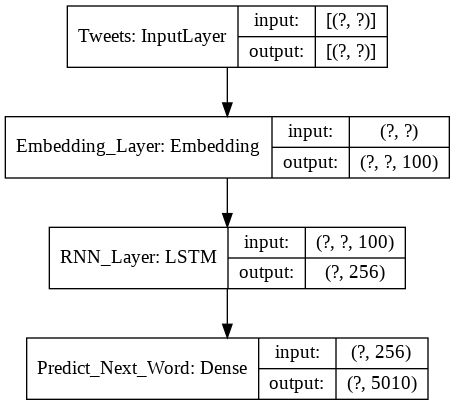

In [0]:
# plot model structure
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

## Train Model

In [0]:
# initialize variables for the callback functions in the model
seq_length = 20
start_tweet = '| ' * seq_length
token_type = 'word'

# length of training
epochs = 20
batch_size = 128
num_batches = int(len(X) / batch_size)

print("Total Batches:", str(num_batches), "\n")


# Record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()


model.fit(X, y, 
          validation_split=0.15,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks = [callback, checkpoint, earlystop], 
          shuffle = True)

## Save Model
model_saved_name = user + '_chatbot_model.h5'
model.save_weights(model_saved_name)

end = datetime.datetime.now()
time_diff = end-start
print()
print()
print('Time to train = {}'.format(time_diff))

Total Batches: 933 

Train on 101561 samples, validate on 17923 samples
Epoch 1/20
101504/101561 [============================>.] - ETA: 0s - loss: 3.7538 - accuracy: 0.4319


--------------------------------------------------
Temp 0.2:

--------------------------------------------------
Temp 0.33:

--------------------------------------------------
Temp 0.5:

--------------------------------------------------
Temp 0.67:

--------------------------------------------------
Temp 1.0:
it you parties . just on years for all by 0 that have sucks . u collected juice . invests defense or dont is for care 2 a global in i worst 0 that games 
--------------------------------------------------




Epoch 00001: loss improved from 4.35141 to 3.75347, saving model to Schwimer_best_model.h5
101561/101561 [==============================] - 274s 3ms/sample - loss: 3.7535 - accuracy: 0.4320 - val_loss: 2.4326 - val_accuracy: 0.6607
Epoch 2/20
101504/101561 [============================>.] - ETA: 0s - lo

## Plot Model Training

### Accuracy

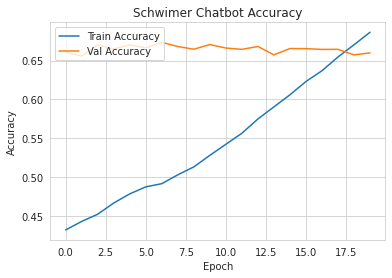

In [0]:
# Plot training & validation accuracy values
plot_title = user + " Chatbot Accuracy"
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title(plot_title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='upper left')
plt.show()

### Loss/Cost

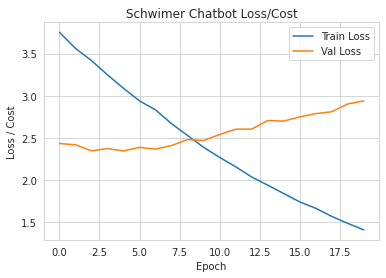

In [0]:
# Plot training & validation loss values
plot_title = user + " Chatbot Loss/Cost"
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title(plot_title)
plt.ylabel('Loss / Cost')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

## Use Chatbot

### Load Best Model

In [0]:
# load best saved model
best_model = load_model(filepath)

### Temperature: 0.1

In [0]:
# Chatbot's new Tweet
temp = 0.1
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.1

Schwimer Chatbot Tweet 1:
i have a venmo account that proves i have told me every single world . i have no athleticism to compete . 

Schwimer Chatbot Tweet 2:
i am not frustrated at all . . . i love to baptize the stuff on ur salon 

Schwimer Chatbot Tweet 3:
i have a venmo account that proves i have told me every single amount of our picks are the market . the market is the smallest line of the closing line . 

Schwimer Chatbot Tweet 4:
i am not frustrated at all . . . i love to baptize the stop light 

Schwimer Chatbot Tweet 5:
i have a venmo account that proves i have told me every single world . i have no athleticism to compete . 



### Temperature: 0.2

In [0]:
# Chatbot's new Tweet
temp = 0.2
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.2

Schwimer Chatbot Tweet 1:
no . we are currently able to pay you + 2 3 0 units on our fee . 

Schwimer Chatbot Tweet 2:
i am not frustrated at all . . . i have always seen the game though . . . 

Schwimer Chatbot Tweet 3:
the closer we will be able to verify for any games . we have never had a 5 0 % chance to win . 

Schwimer Chatbot Tweet 4:
we are not dealing with those . everything is the person that should be on the same thing . 

Schwimer Chatbot Tweet 5:
i have not questioned any of the jambos . i have no idea . . . thanks for the advice . 



### Temperature: 0.3

In [0]:
# Chatbot's new Tweet
temp = 0.3
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.3

Schwimer Chatbot Tweet 1:
yes . . . i will be the nhl right now . . . what did i have the idea 

Schwimer Chatbot Tweet 2:
i have a venmo account that proves i make sure they are the problem . i will be able to get it . 

Schwimer Chatbot Tweet 3:
i am not minor league advance . ill do the answer for all the team . . . neither r the issue in a bus 

Schwimer Chatbot Tweet 4:
this is the best reason we have made to have a lot of our own listeners . they will score the ship . 

Schwimer Chatbot Tweet 5:
we are not dealing with that . we have a units calculator on our site . so we lose for the lines and only incentives are . period . 



### Temperature: 0.4

In [0]:
# Chatbot's new Tweet
temp = 0.4
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.4

Schwimer Chatbot Tweet 1:
you are a brain would have gone by a very long group . if they dont believe it you say . 

Schwimer Chatbot Tweet 2:
we are not dealing with those . everything . we have backed up shortly . while we are 1 0 thousand . 

Schwimer Chatbot Tweet 3:
if you think we will see our edge and you bought the money in our picks . the likelihood of our system correctly and only closing line . 

Schwimer Chatbot Tweet 4:
that is the best week 1 0 1 0 % covers the site . a good reason ? 

Schwimer Chatbot Tweet 5:
you are 1 0 0 % correct . . . im not a lot of fun . . . im not nearly signing up . 



### Temperature: 0.5

In [0]:
# Chatbot's new Tweet
temp = 0.5
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.5

Schwimer Chatbot Tweet 1:
of course . not stating good . . . i will be the team when i was gonna face . they have a lot of respect and what they have . give the concerns that is in the states . we will be able to explain what happened . i am not make a single dollar standard . i said doesnt mean we will be breaking the law . predicting outcomes of mgm would be able to make sure we still have a different chance to win it . 

Schwimer Chatbot Tweet 2:
why would you accept money by how we define money ? please read our detailed write up on our subscribers . they can verify our record vs . closing lines . 

Schwimer Chatbot Tweet 3:
yes . do you get it from your money ? if you are missing something you say you are right you get 1 0 0 thousand if you are wrong . 

Schwimer Chatbot Tweet 4:
" representing my first half to match ! excited to be a title tonight ! excited to watch the tennis ! 

Schwimer Chatbot Tweet 5:
i would be a fool if you cant give me a single people gu

### Temperature: 0.6

In [0]:
# Chatbot's new Tweet
temp = 0.6
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.6

Schwimer Chatbot Tweet 1:
its a bad start ! iv been a lot of fun at each half ? i'm the top 2 th . . . 

Schwimer Chatbot Tweet 2:
just agree with phuturephilles you not get the same time to stay with the whole terms of their service . 

Schwimer Chatbot Tweet 3:
if you dont believe that then put your money where your mouth is . we are giving you ! 

Schwimer Chatbot Tweet 4:
i had a side to one before the one of my twitter . i had a great time for hating the space . i had 6 5 year old and looks to come out of a year i go 

Schwimer Chatbot Tweet 5:
the feeling of the phillies looks into my aa game to stay ( ( 5 0 % of 



### Temperature: 0.7

In [0]:
# Chatbot's new Tweet
temp = 0.7
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.7

Schwimer Chatbot Tweet 1:
if you are wrong . they are giving our money where our mouth is . we are giving you ! 

Schwimer Chatbot Tweet 2:
we think not a subscriber . . . its a big fine tuner . . . so much i r any followers 

Schwimer Chatbot Tweet 3:
if you believe in person . provide financial value for you ! we have a reason besides there is for the top a long write up for the cold . 

Schwimer Chatbot Tweet 4:
if thats the game of ! . . . i have no smart win in football . . . thanks baseball and left made the second directly urias - 2 on over 

Schwimer Chatbot Tweet 5:
we are 1 week package that is 2 7 thousand if we lose everything on says we get our money up front from 2 2 0 . jambos goes in jambos record and get $ 3 0 0 0 - 1 8 . 5 % mlb mlb . 



### Temperature: 0.8

In [0]:
# Chatbot's new Tweet
temp = 0.8
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.8

Schwimer Chatbot Tweet 1:
good . and will you recommend the birthday wishes . especially about the sweet present . 

Schwimer Chatbot Tweet 2:
im going to getting a realllly tough game . . . ran up that . . . i think the most logical good team and will be called them out . 

Schwimer Chatbot Tweet 3:
our plan covers the very tough to game . . . glad i am the team r the outing that i have nd several long term at home . 

Schwimer Chatbot Tweet 4:
this is a 6 0 0 0 ! company is a day . . . you think we didnt need to make sure from your reality . 

Schwimer Chatbot Tweet 5:
that is a big day to start a dream to take 5 min drive i will ask and more questions ? 



### Temperature: 0.9

In [0]:
# Chatbot's new Tweet
temp = 0.9
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.9

Schwimer Chatbot Tweet 1:
r the leafs have fun to 2 0 0 % factual . . . one live park than actual play ! 

Schwimer Chatbot Tweet 2:
hahaha . lets do u have any healthy from would rec when you get 1 0 0 . you should never accept us back . what can check our money at $ 1 m 3 thousand . if we rattled with the amount you would sign up . can you lose $ 3 0 0 0 0 0 0 0 $ ( 1 0 0 0 0 . 

Schwimer Chatbot Tweet 3:
if u wanna give you 1 0 0 thousand . . . it is the sun at home . im not on those and would love so much ) 

Schwimer Chatbot Tweet 4:
i really believe they are not wrong from . if jambos i was exposed . actions can play any recs use the vast majority of the legitimacy of the record . we are in the states and so insider maker . too much is a week valuation . will review everything on the jags / titans game 

Schwimer Chatbot Tweet 5:
no . and the led baseball in attendance despite the worst player ? do you know any scary team are any baseball ? 



### Temperature: 1.0

In [0]:
# Chatbot's new Tweet
temp = 1.0
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 1.0

Schwimer Chatbot Tweet 1:
came to shout out to bed : it 1 2 blake female . something is a must vision outing to like the inaccuracies of 

Schwimer Chatbot Tweet 2:
our auditors would be surprised if you but like every single definition of that bet in 1 unit ! or only would reason become a big factor plus . what do for all our service . that is not fair bs . i dont take the same for a financial cat . 

Schwimer Chatbot Tweet 3:
i wouldnt go on a person most while . i will be sure . . . everyone more up yet . 

Schwimer Chatbot Tweet 4:
" . . . the free for a shelf release than last week . i get 6 7 - 1 ! 

Schwimer Chatbot Tweet 5:
clv thought we are going to do is your email . where is not transparent at everyone . you claim we believe our espn will track and compare what we will burn the beginning . its the model is financial value . 



# Pikachu (@pikachuBets)

In [0]:
# define twitter user
user = "Pikachu"

## Create Vocabulary

In [0]:
# initialize tokenizer
tokenizer = Tokenizer(char_level = False, filters = '', num_words=5500)

# fit tokenizer on tweets
tokenizer.fit_on_texts([pikachu])

# tokenize tweets
token_list = tokenizer.texts_to_sequences([pikachu])[0]

# get vocabulary in tweets
all_words = len(tokenizer.word_counts) + 1
total_words = len(set(token_list)) + 1

In [0]:
print(user, "has a vocabulary of", all_words, "total words!")
if all_words > 5500:
    print("\n", user, "uses so many words that we need to limit his vocabulary for modeling to only", total_words, "total words!")

Pikachu has a vocabulary of 7195 total words!

 Pikachu uses so many words that we need to limit his vocabulary for modeling to only 5500 total words!


## Create Training Data

Convert tweets into sequences to input into the RNN model

In [0]:
# step = the number of words the sequence moves before creating a new sequence
step = 1
# total words in each sequence
seq_length = 20

## create training data
X, y, num_seq = generate_sequences(token_list, step = 1)

Number of prediction classes (Total Vocabulary): 5500
Number of sequences: 142791 



In [0]:
# make sure Y data lines up with the function output above
y.shape

(142791, 5500)

## Build Model

### Early Stopping Settings

In [0]:
earlystop = EarlyStopping(monitor = 'loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

### Model Checkpoint Settings

In [0]:
# output file to save the best model
filepath =  user + '_best_model.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

### Callback Function

In [0]:
# create callback function to generate tweets at different temperatures for the chatbot after each epoch
callback = LambdaCallback(on_epoch_end = on_epoch_end)

### Neural Network Architecture

In [0]:
# name model
model_name = user + "_Chatbot"

# number of neurons in LSTM layer
n_units = 256

# Embedding Dimensions
embedding_size = 100

# Input of model
text_in = Input(shape = (None,), name = "Tweets")

# Embedding layer
embedding = Embedding(total_words, embedding_size, name = "Embedding_Layer")

# Start of Model
x = embedding(text_in)

# LSTM RNN layer
x = LSTM(n_units, name = "RNN_Layer")(x)

# Output layer
text_out = Dense(total_words, activation = 'softmax', name = "Predict_Next_Word")(x)

# Complete model
model = Model(text_in, text_out, name = model_name)

# Optimizer function
opti = Adam(learning_rate = 0.001)

# Compile model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opti, 
              metrics = ['accuracy'])

### View Model

In [0]:
model.summary()

Model: "Pikachu_Chatbot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Tweets (InputLayer)          [(None, None)]            0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, None, 100)         550000    
_________________________________________________________________
RNN_Layer (LSTM)             (None, 256)               365568    
_________________________________________________________________
Predict_Next_Word (Dense)    (None, 5500)              1413500   
Total params: 2,329,068
Trainable params: 2,329,068
Non-trainable params: 0
_________________________________________________________________


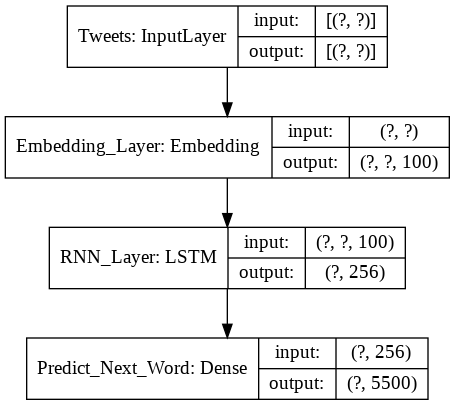

In [0]:
# plot model structure
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

## Train Model

In [0]:
# initialize variables for the callback functions in the model
seq_length = 20
start_tweet = '| ' * seq_length
token_type = 'word'

# length of training
epochs = 20
batch_size = 64
num_batches = int(len(X) / batch_size)

print("Total Batches:", str(num_batches), "\n")


# Record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()


model.fit(X, y, 
          validation_split=0.15,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks = [callback, checkpoint, earlystop], 
          shuffle = True)

## Save Model
model_saved_name = user + '_chatbot_model.h5'
model.save_weights(model_saved_name)

end = datetime.datetime.now()
time_diff = end-start
print()
print()
print('Time to train = {}'.format(time_diff))

Total Batches: 2231 

Train on 121372 samples, validate on 21419 samples
Epoch 1/20
121344/121372 [============================>.] - ETA: 0s - loss: 4.2060 - accuracy: 0.3983


--------------------------------------------------
Temp 0.2:

--------------------------------------------------
Temp 0.33:

--------------------------------------------------
Temp 0.5:
did . / 1 1 8 8 - 1 8 2 1 5 + 1 . 5 5 5 . - 1 5 5 6 . . : 5 5 5 0 5 6 5 5 5 . . . 5 5 5 5 + 5 5 . + 2 . 5 5 4 . 5 0 5 - 1 - 2 5 5 5 5 5 5 4 - 1 - 5 . 5 5 5 5 5 5 9 7 5 5 5 - 1 7 . - 1 . 5 5 5 1 5 5 5 5 . . . 5 - 6 5 5 6 . 5 5 . 5 5 5 5 5 . . . 5 2 . 7 - + 1 9 5 5 - 7 . . . . - + 0 5 5 5 - 3 5 5 % + 3 5 5 5 . 5 % + 1 6 5 5 . . . 1 1 5 5 5 5 5 0 . 5 5 5 5 - 1 5 5 . . . 5 7 . 5 5 . 0 2 6 0 5 9 5 + 2 1 5 . 5 . 5 - 1 5 . 5 5 5 5 : 5 . - 1 - 1 5 0 5 5 5 + 7 . 5 - 2 5 - 1 9 5 6 5 . + 7 - 8 5 5 5 : 5 - 9 . 5 3 5 5 + 1 7 5 5 o . 5 - 1 1 . 5 3 5 5 5 . . . + 1 6 5 5 5 % 5 5 . 5 - 2 2 0 5 7 5 5 5 5 . 5 5 7 5 . 5 8 5 5 + 7 5 5 5 - 4 + 5 . - .

The model disconnected during training during the 12th Epoch.... Shit...

I'm not sure how to pick up training from this point with the saved model...

In [0]:
### TAKE 2....


# initialize variables for the callback functions in the model
seq_length = 20
start_tweet = '| ' * seq_length
token_type = 'word'

# length of training
epochs = 20
batch_size = 64
num_batches = int(len(X) / batch_size)

print("Total Batches:", str(num_batches), "\n")


# Record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()


model.fit(X, y, 
          validation_split=0.15,
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks = [callback, checkpoint, earlystop], 
          shuffle = True)

## Save Model
model_saved_name = user + '_chatbot_model.h5'
model.save_weights(model_saved_name)

end = datetime.datetime.now()
time_diff = end-start
print()
print()
print('Time to train = {}'.format(time_diff))

Total Batches: 2231 

Train on 121372 samples, validate on 21419 samples
Epoch 1/20
121344/121372 [============================>.] - ETA: 0s - loss: 4.2095 - accuracy: 0.3946


--------------------------------------------------
Temp 0.2:

--------------------------------------------------
Temp 0.33:

--------------------------------------------------
Temp 0.5:

--------------------------------------------------
Temp 0.67:

--------------------------------------------------
Temp 1.0:

--------------------------------------------------




Epoch 00001: loss improved from inf to 4.20944, saving model to Pikachu_best_model.h5
121372/121372 [==============================] - 189s 2ms/sample - loss: 4.2094 - accuracy: 0.3946 - val_loss: 2.1925 - val_accuracy: 0.6679
Epoch 2/20
121344/121372 [============================>.] - ETA: 0s - loss: 3.7571 - accuracy: 0.4192


--------------------------------------------------
Temp 0.2:
i don't the the time of the . . . . . . . . . . . . . . . . . . 

## Plot Model Training

### Accuracy

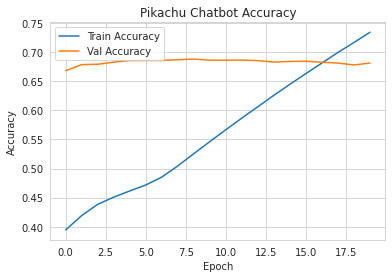

In [0]:
# Plot training & validation accuracy values
plot_title = user + " Chatbot Accuracy"
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title(plot_title)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='upper left')
plt.show()

### Loss/Cost

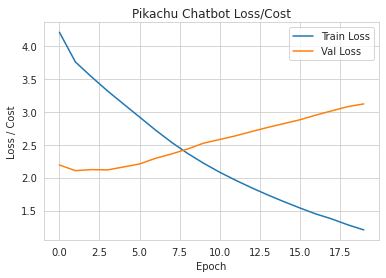

In [0]:
# Plot training & validation loss values
plot_title = user + " Chatbot Loss/Cost"
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title(plot_title)
plt.ylabel('Loss / Cost')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

## Use Chatbot

### Load Best Model

In [0]:
# load best saved model
best_model = load_model(filepath)

### Temperature: 0.1

In [0]:
# Chatbot's new Tweet
temp = 0.1
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.1

Pikachu Chatbot Tweet 1:
lol . visit queens . it's not even funny the data ( ( / 1 ) is a . 

Pikachu Chatbot Tweet 2:
this is not a fucking difficult concept to outs . you are missing the sharp stuff he's been out . you are due to a " audience is worth . lol 

Pikachu Chatbot Tweet 3:
i agree . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

### Temperature: 0.2

In [0]:
# Chatbot's new Tweet
temp = 0.2
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.2

Pikachu Chatbot Tweet 1:
lol . visit queens . it's not even funny the data ( ( / 1 ) is a market . but wait you have vastly underperformed all down with the finish 

Pikachu Chatbot Tweet 2:
lol . visit queens . it's not even close . legal lines just say wow 

Pikachu Chatbot Tweet 3:
lol . visit queens . it's not even funny the data ( ( / 1 ) is a . 

Pikachu Chatbot Tweet 4:
i am uber aware tyvm . why are you obsessed with dicks 

Pikachu Chatbot Tweet 5:
i don't see this game or something . it wasn't a pro and reliable . zero . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

### Temperature: 0.3

In [0]:
# Chatbot's new Tweet
temp = 0.3
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.3

Pikachu Chatbot Tweet 1:
i agree . you are a capable of pokmon isnt related to make it off a lot of shit . i don't want to get ahead of shit except memes " 

Pikachu Chatbot Tweet 2:
also . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Temperature: 0.4

In [0]:
# Chatbot's new Tweet
temp = 0.4
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.4

Pikachu Chatbot Tweet 1:
ill lay - 2 0 0 0 for a . maybe already time . you are a participant in a pancake ? idk ty 

Pikachu Chatbot Tweet 2:
look at offensive numbers you might become to admit the market profitably he's operating media than he idiot media 

Pikachu Chatbot Tweet 3:
lol . visit queens . it's not even funny the data ( no / s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Temperature: 0.5

In [0]:
# Chatbot's new Tweet
temp = 0.5
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.5

Pikachu Chatbot Tweet 1:
" i don't get shit . prob just retire in february but i just thought it all and prove to work ? 

Pikachu Chatbot Tweet 2:
4 / 2 early china cba sichuan + 1 . 5 beijing d + 2 1 1 

Pikachu Chatbot Tweet 3:
also . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Temperature: 0.6

In [0]:
# Chatbot's new Tweet
temp = 0.6
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.6

Pikachu Chatbot Tweet 1:
/ r / sportsbook musings pt . 2 2 . 5 adriatic aba mornar + 4 . 5 8 % no vig reverse sweep and sweep again * 

Pikachu Chatbot Tweet 2:
wnba " is a fucking bullshit argument " you listen to a tout " finding this worth of claims to process $ e . g - edged on these $ 5 0 0 sub is a - 1 5 0 . - ev doesn't mean it is not - 0 0 0 . why do you say " several his " 

Pikachu Chatbot Tweet 3:
lol . you should be interested in a highly efficient you makes he mention of them around 

Pikachu Chatbot Tweet 4:
no chance i currently owe anyone money . i suppose they reflect the average and the other reason every single coming of the most signed / twitter det of the bench 

Pikachu Chatbot Tweet 5:
if the only thing i looked at and purpose of the most basic of the industry 6 - pt clusterfuck after a load of gambling twitter . there are not - up 4 0 . 5 - 6 9 % limits in 5 0 0 9 % . do your fire are still be up . so i think it were only good accounts . you're

### Temperature: 0.7

In [0]:
# Chatbot's new Tweet
temp = 0.7
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.7

Pikachu Chatbot Tweet 1:
this is showing up for 5 d and retire for nbl d at home point . ty reading 

Pikachu Chatbot Tweet 2:
7 / 1 0 wnba chi + 6 . 5 more day at june . pretty good today . prob a day of lag is . bol opener might a very hard . get an guess 

Pikachu Chatbot Tweet 3:
love waking up to do you need to know what they do without " 

Pikachu Chatbot Tweet 4:
you sound like a twitter concept of their own plays . i have a app way to say when you don't ask for the very losses . " 

Pikachu Chatbot Tweet 5:
this is not up . if the one of them . you don't know enough mid - level but who wants it to where i am the fuck 



### Temperature: 0.8

In [0]:
# Chatbot's new Tweet
temp = 0.8
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.8

Pikachu Chatbot Tweet 1:
millions on no surprise he thinks guys going to be an edge . also are still hate here 

Pikachu Chatbot Tweet 2:
the question he knows that he thinks the market makes for come from 

Pikachu Chatbot Tweet 3:
1 2 / 2 0 ivy cbb 1 9 8 hou - 3 season : 1 1 9 - 1 2 season harvard o 9 - 1 . 4 5 % plays this steam ( did / palestra but a difference . 2 1 8 3 mvsu + 7 . 5 / - league 2 0 ! 2 units season : so ya boy's good already already when whatever it goes at 6 5 min so it's you . youre here . 

Pikachu Chatbot Tweet 4:
good rant : all but i work out like 2 0 0 more 

Pikachu Chatbot Tweet 5:
lol i understand how most random number generator move by 1 1 0 8 and 2 nd 6 q / 9 7 s while i need a neutral third - party arbitrator bullshit while the other nights when it come . 



### Temperature: 0.9

In [0]:
# Chatbot's new Tweet
temp = 0.9
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 0.9

Pikachu Chatbot Tweet 1:
what do your korean is . your big is to talk about shit so strong . you are just a short - time . thats next world w / zero totals now or bet it was a 1 0 0 % of 3 5 % midday then you wouldn't care how to need to reasoning on . snorefest ? ? 

Pikachu Chatbot Tweet 2:
look at now long last year : at least 5 0 - 2 . 5 now that should be fire . dont go lmao 

Pikachu Chatbot Tweet 3:
well my backtest last time on betting . has a ) for this then i had coach amaker already . neither man 

Pikachu Chatbot Tweet 4:
int'l baskets 2 1 9 - 1 2 9 + 1 7 . 5 4 units + 9 . 0 i am part of just saying lol 

Pikachu Chatbot Tweet 5:
5 got + 5 . 5 - 1 9 . 5 good good - 1 . 5 ( tips : 1 0 % ft ain't diff - 3 . 5 got o 1 0 7 at the tweet . ok . soccer is always really like you only 2 0 % before . take looks like a comment . 2 h has $ 1 6 0 . 0 0 units 



### Temperature: 1.0

In [0]:
# Chatbot's new Tweet
temp = 1.0
print("Temperature: " + str(temp))
print()
print(user + " Chatbot Tweet 1:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 2:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 3:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 4:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()
print(user + " Chatbot Tweet 5:")
print(generate_text(seed_text = "", next_words = 500, model = best_model, max_sequence_len= 20, temp = temp))
print()

Temperature: 1.0

Pikachu Chatbot Tweet 1:
finishing the first half 1 0 top 2 0 its off that and you count bc it's both . 

Pikachu Chatbot Tweet 2:
instead of an opinion . his company is incredibly enough . to cherry run 

Pikachu Chatbot Tweet 3:
lol only only records . be it well is here . your article are top - 8 times 2 h bets in 1 6 - 1 4 ) and opened - 1 . 5 5 % good at 4 0 0 tweets to some book when its that thats why now is impossible with you still his word hmu tho 

Pikachu Chatbot Tweet 4:
ill are not about a referral company to fight up 2 . he are no legal tos makes this irl for nba then . might sprinkle some steam and deleted all of them . what does it turn doesn't be trying to get betting . no proof he deserves ppl guys know what i spend paid " no but it was the target audience to play for it used to $ 2 - 0 thousand to lose probably and w / inefficiencies before there was 2 0 thousand . 3 . 5 . still impossible . 

Pikachu Chatbot Tweet 5:
finishing the cause / 5 0 / 5 